In [1]:
import sys
sys.path.append('../utils/')
sys.path.append('../paviaUTools/')

import matplotlib.pyplot as plt
from datasetLoader import datasetLoader
import os
import numpy as np
from whole_pipeline import whole_pipeline_all, whole_pipeline_divided, whole_pipeline_divided_parallel
import torch
from plots import *
from weights_anal import *
import gc
from MetaLearner import HDDOnBands
import consts
from HDD_HDE import HDD_HDE
import DistancesHandler

torch.cuda.empty_cache()
gc.collect()

%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\amirb\AppData\Local\Programs\Python\Python38\lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


cpu


In [5]:
parent_dir = os.path.join(os.getcwd(),"..")
csv_path = os.path.join(parent_dir, 'datasets', 'paviaU.csv')
gt_path = os.path.join(parent_dir, 'datasets', 'paviaU_gt.csv')
# csv_path = os.path.join(parent_dir, 'datasets', 'pavia.csv')
# gt_path = os.path.join(parent_dir, 'datasets', 'pavia_gt.csv')
# csv_path = os.path.join(parent_dir, 'datasets', 'KSC.csv')
# gt_path = os.path.join(parent_dir, 'datasets', 'KSC_gt.csv')

dsl = datasetLoader(csv_path, gt_path)

df = dsl.read_dataset(gt=False)
X = np.array(df)
X = X.reshape((610,340, 103))
# X = X.reshape((1096, 715, 102))
# X = X.reshape((512, 614, 176))

df = dsl.read_dataset(gt=True)
y = np.array(df)

factor = 29
rows_factor = factor
cols_factor = factor

X = torch.from_numpy(X)
y = torch.from_numpy(y)

X = X.to(device)
y = y.to(device)

SERIAL WASSER TIME:  2.9954986572265625
IMPROVEMENT WASSER TIME:  1.4168808460235596
IS IMPROVEMENT GOOD? True
is symmetric?  tensor(True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


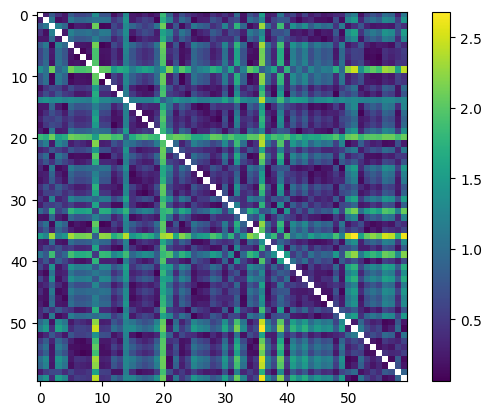

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

factor = 61
is_normalize_each_band = True
method_label_patch = 'most_common'

distances_bands = HDDOnBands.run(X, metric=consts.METRIC_BANDS)
distances_bands = distances_bands.to(device)

if is_normalize_each_band:
    X_tmp = HDD_HDE.normalize_each_band(X)
else:
    X_tmp = X
    
X_patches, _, _= HDD_HDE.patch_data_class(X_tmp, factor, factor, y, method_label_patch)
distance_handler = DistancesHandler.DistanceHandler(consts.WASSERSTEIN,distances_bands)
precomputed_distances = distance_handler.calc_distances(X_patches)

print("is symmetric? ", (precomputed_distances.transpose(0, 1) == precomputed_distances).all())
# check = precomputed_distances.clone()
# check.fill_diagonal_(0)
# print("is diag 0? ", (precomputed_distances == check).all())

diag = torch.diag(precomputed_distances)
print(diag)

show_distances(precomputed_distances)

In [ ]:

for val in [5,7,9,11,13,15,17,19]:
    consts.CONST_K = val
    for C in [1,2,5,10]:
        consts.CONST_C = C
        distances = HDDOnBands.run(X, 'cosine', factors_for_batch=None)
        if val!=5:
            print("is equal? ", np.allclose(distances, keep))
        keep = distances
        print("K=", consts.CONST_K, " C=", consts.CONST_C)
        show_distances(distances)


# weights, dist_batches = HDDOnBands.createL1WeightedBatches(X, normalize=False)

# show_weights(weights, is_normalized=False)


# plot_tree(distances.cpu().numpy())

: 

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

train_acc,test_acc, test_preds,test_gt = whole_pipeline_all(X,y, rows_factor, cols_factor, is_normalize_each_band=True, method_label_patch='most_common')

confusion_mat(test_gt,test_preds, range(1,10))


: 

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

weights, dist_batches = HDDOnBands.createUniformWeightedBatches(X, clusters_amount=3)

# print(dist_batches[1])

# print(dist_batches)

train_acc,test_acc, test_preds,test_gt = whole_pipeline_divided_parallel(X,y, rows_factor, cols_factor, is_normalize_each_band=True, method_label_patch='most_common', weights=weights, distance_batches= dist_batches)

confusion_mat(test_gt,test_preds, range(1,10))


: 